In [26]:
import sys
sys.path.append("../")
import os
from encoding.encoding import encoder
import numpy as np
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend
import matplotlib.pyplot as plt
backend = set_backend("torch_cuda", on_error="warn")

In [25]:
resp_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023"
stim_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023/features"
save_path = "/mount/nfs5/matsuyama-takuya/dataset/alg2023/results"
model_name = "eva02-clip-enormous"
subjects = [f"subj{str(s).zfill(2)}" for s in range(1, 9)]
layer = 31
test_split = 0.1
max_n_samples = 8779

In [14]:
subjects_scores = {}
for sub in subjects:
    resp_lh = np.load(f"{resp_path}/{sub}/training_split/training_fmri/lh_training_fmri.npy")
    resp_rh = np.load(f"{resp_path}/{sub}/training_split/training_fmri/rh_training_fmri.npy")
    resp = np.concatenate([resp_lh, resp_rh], axis=1)
    resp = resp[:max_n_samples]
    print(resp.shape)

    stim = np.load(f"{stim_path}/{model_name}/{sub}/training/layer{layer}.npy")
    stim = stim[:max_n_samples]
    print(stim.shape)

    n_sample = resp.shape[0]
    n_sample_test = int(n_sample * test_split)
    n_sample_trn = int(n_sample * (1 - test_split))
    resp_trn = resp[:n_sample_trn]
    resp_test = resp[-n_sample_test:]
    print(f"trn_n_samples = {resp_trn.shape[0]}, test_n_samples = {resp_test.shape[0]}")
    scaled_n_sample_trn = np.geomspace(10, n_sample_trn, 10, dtype=int)
    print(f"Log scaled trn_n_samples split = {scaled_n_sample_trn}")

    flat_stim =stim.reshape(stim.shape[0], -1)
    flat_stim_trn = flat_stim[:n_sample_trn]
    flat_stim_test = flat_stim[-n_sample_test:]
    scaled_scores = []
    for n_sample in scaled_n_sample_trn:
        if n_sample > 5000:
            break
        scaled_stim = flat_stim[:n_sample]
        scaled_resp = resp[:n_sample]
        print(f"Number of training samples: {n_sample}")
        _, ridge = encoder(scaled_stim, scaled_resp, return_model=True)
        resp_pred_test = ridge.predict(flat_stim_test)
        scores = correlation_score(resp_test, resp_pred_test)
        scores = backend.to_numpy(scores)
        print(f"Mean test scores: {np.mean(scores)}")
        scaled_scores.append(np.mean(scores))
    subjects_scores[sub] = scaled_scores

(8779, 39548)
(8779, 1792, 16, 16)
trn_n_samples = 7901, test_n_samples = 877
Log scaled trn_n_samples split = [  10   20   44   92  194  407  854 1793 3764 7901]
Number of training samples: 10
Solving kernel ridge regression...
Mean cv scores: 0.04521722346544266
Mean test scores: 0.13329987227916718
Number of training samples: 20
Solving kernel ridge regression...
Mean cv scores: 0.2572540044784546
Mean test scores: 0.14309510588645935
Number of training samples: 44
Solving kernel ridge regression...
Mean cv scores: 0.24601870775222778
Mean test scores: 0.2081712782382965
Number of training samples: 92
Solving kernel ridge regression...
Mean cv scores: 0.27154210209846497
Mean test scores: 0.25914669036865234
Number of training samples: 194
Solving kernel ridge regression...
Mean cv scores: 0.29636871814727783
Mean test scores: 0.32721254229545593
Number of training samples: 407
Solving kernel ridge regression...
Mean cv scores: 0.3618300259113312
Mean test scores: 0.3694280385971069

subj01
subj02
subj03
subj04
subj05
subj06
subj07
subj08


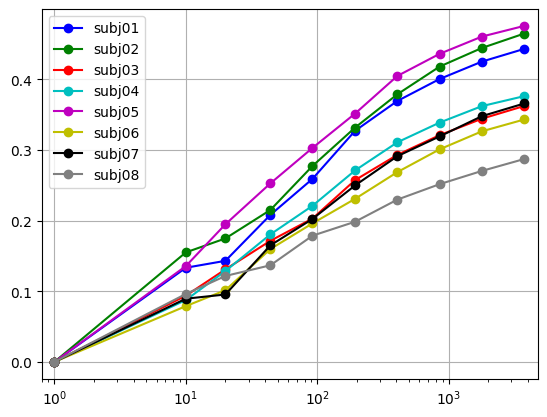

In [29]:
color_list =['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.5']
fig = plt.figure()
for (sub, scores), color in zip(subjects_scores.items(), color_list):
    print(sub)
    x = scaled_n_sample_trn[:9]
    x = np.append(1, x)
    y = scores
    y = np.append(0, y)
    plt.plot(x, y, marker="o", color=color, label=sub)
plt.xscale("log")
plt.xlim([0.8, x.max()+ 1000])
# plt.ylim([-0,1, y.max()+0.1])
plt.grid()
plt.legend()
plt.show()
fig_save_path = f"{save_path}/{model_name}/figures"
os.makedirs(fig_save_path, exist_ok=True)
fig.savefig(f"{fig_save_path}/scaling_data_scores.png")